In [27]:

import requests
import time
import random
import matplotlib.pyplot as plt 

import pandas as pd
import csv



First things first, we want to find a large amount of airports to collect data about. I found this spreadsheet online with a airports all around the world, so lets bring it into our project.

In [ ]:
us_airport_list = list()

# This will just give us a list of US airport codes.
with open('airport-codes.csv', 'r') as airport_file:
    for location in csv.DictReader(airport_file):
        if location['iso_country'] == 'US' and location['iata_code'] != '':
            if 'airport' in location['type']:
                us_airport_list.append(location['iata_code'])
        


print("Number of airports collected: " + str(len(us_airport_list)))

Now that we know how many airports we want to search for using the API, lets go ahead and see which ones we are sure we can connect to.

In [ ]:
api_prefix = "https://api.aviationapi.com/v1"
weather_list = list()
traffic_list = list()
airports_used = list()
subset = us_airport_list[:1]

# This loop takes a long time to run, but it always results in finding an airport, that has the data we need.
for airport in subset:
    successful = False # Did we successfully find an airport.

    while not successful:
        weather_resp = requests.get(api_prefix + "/weather/metar", params={ "apt": airport})
        traffic_resp = requests.get(api_prefix + "/vatsim/pilots", params={ "apt": airport})
        weather_data_raw = weather_resp.json()
        traffic_data_raw = traffic_resp.json()
        # Keep trying to get both weather and traffic repsonses.
        try:
            visitors  = traffic_data_raw["K" + airport]['Departures']
            if weather_data_raw['status'] == 'error' or traffic_data_raw['status'] == 'error':
                successful = False
                random.shuffle(us_airport_list)
                airport = us_airport_list[:1].pop() # Get a random airport.
        except KeyError: 
            successful = True

        if visitors == []:
            successful = False
            random.shuffle(us_airport_list)
            airport = us_airport_list[:1].pop() # Get a random airport.
        else:
            successful = True


    weather_list.append(weather_data_raw)
    traffic_list.append(traffic_data_raw)
    airports_used.append(airport)

    with open('myairports.csv', 'a', newline='') as csvfile:
        writer = csv.writer(csvfile,delimiter=' ', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow([airport, weather_list, traffic_list])


    

    time.sleep(1)



The code below is for airports WE KNOW will return both types of data for.

In [87]:
codes = {'JFK', 'BWI', 'ILM', 'PVD', 'MEM', 'PHL', 'MIA', 'IAH', 'CVG', 'LAX'}
api_prefix = "https://api.aviationapi.com/v1"
wind_velocities = dict()
flights_in = dict()
flights_out = dict()


for iata_code in codes:
    weather_resp = requests.get(api_prefix + "/weather/metar", params={ "apt": iata_code})
    try:
        airport_metar = weather_resp.json()[f"K{iata_code}"]
        wind_velocities[f"K{iata_code}"] = int(airport_metar['wind_vel'])
    except KeyError:
        continue
    # Record just the wind velocity for each airport
    #time.sleep(1)

for iata_code in codes:
    traffic_resp = requests.get(api_prefix + "/vatsim/pilots", params={ "apt": iata_code})
    try:
        traffic_info = traffic_resp.json()[f"K{iata_code}"]
        arrivals = len(traffic_info['Arrivals'])
        departures = len(traffic_info['Departures'])
        flights_in[f"{iata_code}"] = arrivals
        flights_out[f"{iata_code}"] = departures
    except KeyError:
         continue
    # Record just the number of entries into departure, + arrivalsl
    time.sleep(1)

print(wind_velocities)


{'KMIA': 11, 'KCVG': 10, 'KMEM': 10, 'KJFK': 6, 'KILM': 5, 'KBWI': 0, 'KPHL': 3, 'KLAX': 10, 'KIAH': 18, 'KPVD': 5}


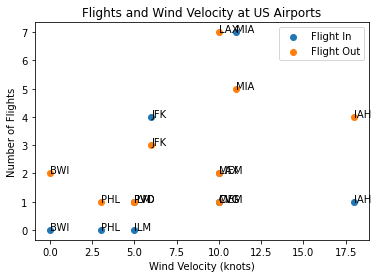

In [88]:

plt.title("Flights and Wind Velocity at US Airports",fontsize=12)
y = list(flights_in.values())
x =  list(wind_velocities.values())
y2 = list(flights_out.values())
plt.scatter(x, y)
plt.scatter(x, y2)
plt.xlabel("Wind Velocity (knots)")
plt.ylabel("Number of Flights")
plt.legend(['Flight In','Flight Out'])

for i, label in enumerate(flights_in.keys()):
    plt.text(x[i], y[i], label)
    plt.text(x[i], y2[i], label)



<BarContainer object of 9 artists>

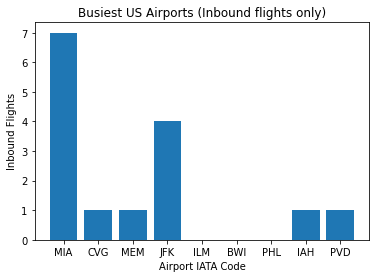

In [85]:
total_flights = list()
for k in flights_in.keys():
    total_flights.append(flights_out[k] + flights_in[k])

plt.title("Busiest US Airports (Inbound flights only)")
x = list(flights_in.keys())
y = list(flights_in.values())
plt.xlabel("Airport IATA Code")
plt.ylabel("Inbound Flights")
plt.bar(x, y)

<BarContainer object of 10 artists>

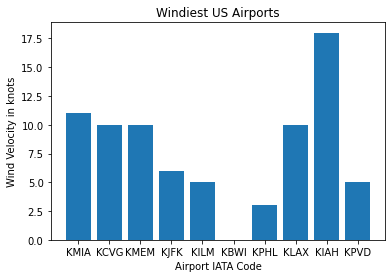

In [89]:
plt.title("Windiest US Airports")
x = list(wind_velocities.keys())
y = list(wind_velocities.values())
plt.xlabel("Airport IATA Code")
plt.ylabel("Wind Velocity in knots")
plt.bar(x, y)

Analyze
# How many flights was the max?
# What was the recorded wind velocity
# How does wind velocity relate to the number of flights.

In [53]:

print(f"Highest number of inbound flights: {max(flights_in)}: {max(flights_in.values())}")
print(f"Highest number of outbound flights: {max(flights_out)}: {max(flights_out.values())}")
print(wind_velocities[f"K{max(flights_in)}"])

print(f"Highest number of inbound flights: {min(flights_in)}: {min(flights_in.values())}")
print(f"Highest number of outbound flights: {min(flights_out)}: {min(flights_out.values())}")
print(wind_velocities[f"K{min(flights_in)}"])

print(f"Highest WV: {max(wind_velocities)}: {max(wind_velocities.values())}")
print(f"Highest number of outbound flights: {max(flights_out)}: {max(flights_out.values())}")
print(wind_velocities[f"K{max(flights_in)}"])



Highest number of inbound flights: PVD: 7
Highest number of outbound flights: PVD: 5
5
Highest number of inbound flights: BWI: 0
Highest number of outbound flights: BWI: 1
0
Highest WV: KPVD: 15
Highest number of outbound flights: PVD: 5
5
